# License Plate Recognition

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.layers import StringLookup

In [2]:
#!wget https://github.com/shenasa-ai/iranian-car-license-plate/raw/main/iclp-part1.zip
#!unzip -qq iclp-part1.zip

## Load the data

In [3]:
paths = Path().glob('./iclp-part1/*.jpg')
paths = [str(x.absolute()) for x in paths]
labels = [x.split(os.path.sep)[-1].split('_')[0] for x in paths]
print(f'Loaded {len(paths)} images')

Loaded 3000 images


In [4]:
# Do train/test split
train_paths, test_paths, train_labels, test_labels = train_test_split(paths, 
                                                                      labels, 
                                                                      test_size=0.1, 
                                                                      random_state=123)

print(f'Training samples:', len(train_paths))
print(f'Test samples:', len(test_paths))

Training samples: 2700
Test samples: 300


In [5]:
vocabulary = sorted(list(set(x for y in labels for x in y)))
vocabulary.append(' ')
print('Vocabulary:', vocabulary)
print('Vocabulary length:', len(vocabulary))

Vocabulary: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'H', 'J', 'K', 'L', 'M', 'N', 'S', 'T', 'V', 'X', 'Y', 'Z', ' ']
Vocabulary length: 27


In [6]:
tokenizer = StringLookup(vocabulary=vocabulary, oov_token='')
tokenizer_invert = StringLookup(vocabulary=tokenizer.get_vocabulary(), oov_token='', invert=True)

def text_to_ids(text):
    return tokenizer(tf.strings.unicode_split(text, 'UTF-8'))

def ids_to_text(ids):
    return tf.strings.join(tokenizer_invert(ids))

train_labels_tokenized = [text_to_ids(x) for x in train_labels]
test_labels_tokenized = [text_to_ids(x) for x in test_labels]

## Create the pipeline

In [7]:
BATCH_SIZE = 32
BUFFER = 5000
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 64

def load_image(path):
    file = tf.io.read_file(path)
    image = tf.image.decode_jpeg(file, channels=3)
    image = tf.cast(image, tf.float32)
    return image


def normalize(image):
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.transpose(image, perm=[1, 0, 2])
    image = image / 127.5
    image = image - 1
    return image


def get_image_label(path, label):
    image = load_image(path)
    image = normalize(image)
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_tokenized))
train_ds = train_ds.map(get_image_label, num_parallel_calls=AUTOTUNE)

### Visualize some data
Data are fed into the network with images transposed to make the shape of [Batch, Width, Height, 3]; The reason we did this is that we want to read images sequentialy from left to right (albeit we do not exactly read from left to right); imagine it as an image with vertical slices, reading each slice to predict what token comes next.

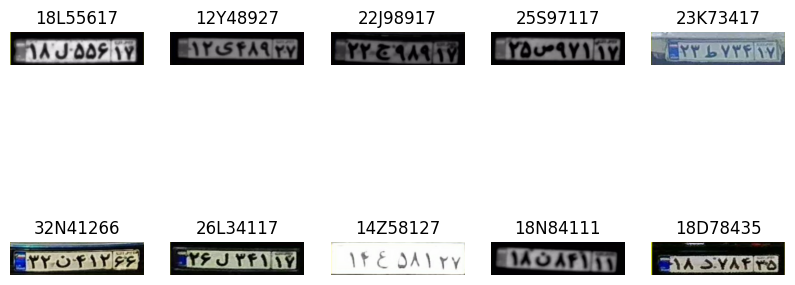

In [8]:
fig = plt.figure(figsize=(10, 5))
i = 0
for img, lbl in train_ds.take(10):
    ax = plt.subplot(2, 5, i + 1) 
    ax.imshow((tf.transpose(img, perm=[1, 0, 2]) + 1) / 2.0)
    ax.set_title(ids_to_text(lbl).numpy().decode('utf-8'))
    ax.axis('off')
    i += 1

In [9]:
train_ds = train_ds.shuffle(BUFFER)
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels_tokenized))
test_ds = test_ds.map(get_image_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [10]:
train_ds.element_spec

(TensorSpec(shape=(None, 256, 64, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 8), dtype=tf.int64, name=None))

## Create the model

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from keras.layers import Layer, LSTM, Bidirectional, Add, Reshape, Input, DepthwiseConv2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.metrics import Metric

`ConvBlock` is defined as a layer doing `BatchNormalization` and applies `ReLU` activation after computing `Conv2D`

In [12]:
class ConvBlock(Layer):
    def __init__(self, filters, kernel_size=(3, 3), momentum=0.99):
        super(ConvBlock, self).__init__()

        self.conv = Conv2D(filters=filters, 
                           kernel_size=kernel_size, 
                           padding='same', 
                           activation='linear', 
                           name='conv_block')
        
        self.bn = BatchNormalization(name='bn', 
                                     momentum=momentum)

        self.act = Activation(activation='relu', 
                              name='act')


    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = self.act(x)
        return x

### Model
Model takes as input batches of images with the shape of `[BATCH_SIZE, IMAGE_WIDTH, IMAGE_HEIGHT, 3]` (Batches of RGB images).<br>
#### Args
- `num_classes`: This is this should be the number of vocabularies. (Note that `num_classes` is one more than number of vocabularies; alternatively we added a space to mimic this)
- `units`: This is a list of integer numbers illustrating units. Length of `units` also defines how many times `MaxPooling2D` is applied on the input.
- `momentum`: This is the input to `BatchNormalization`

In [13]:
class MyModel(Model):
    def __init__(self, num_classes, *, 
                 units, 
                 momentum=0.99, 
                 dropout_rate=0.5, 
                 lstm_dropout_rate=0.2):
        
        super(MyModel, self).__init__()

        self.reduce_factor = len(units)

        self.conv_blocks = [ConvBlock(filters=unit, momentum=momentum) 
                            for unit in units]

        self.dropout = Dropout(dropout_rate, name='dropout')

        self.maxpool = MaxPooling2D(name='maxpool')
        self.dense = Dense(units=units[-1], activation='relu', name='dense')
        self.lstm = Bidirectional(LSTM(units=units[-1], return_sequences=True, dropout=lstm_dropout_rate, name='lstm'))
        self.classify = Dense(num_classes, activation='softmax', name='classifier')


    def build(self, width, height):
        inputs = Input(shape=(width, height, 3))
        self.reshape = Reshape(target_shape=[width // 2 ** self.reduce_factor, -1], name='reshape')
        self.call(inputs)
        self.built = True


    def call(self, inputs, training=False):
        x = inputs
        for conv_block in self.conv_blocks:
            x = conv_block(x, training=training)
            x = self.maxpool(x)
        
        x = self.reshape(x)
        x = self.dense(x)
        x = self.dropout(x, training=training)
        x = self.lstm(x, training=training)
        x = self.classify(x)
        return x

The `CTCLoss` function computes the Connectionist Temporal Classification (CTC) loss for a batch of sequences. This loss function is commonly used in sequence-to-sequence learning problems, such as speech recognition or handwriting recognition, where the alignment between input and output sequences is unknown.

The `CTCLoss` function is typically used as a loss function in training deep learning models where the task involves mapping input sequences to output sequences with unknown alignment.

Parameters
`y_true`: Tensor of true labels with shape `(batch_size, max_label_length)`.
batch_size is the number of sequences in the batch.
max_label_length is the maximum length of the label sequences in the batch. <br>
`y_pred`: Tensor of predicted labels with shape `(batch_size, max_time_step, num_classes)`.
max_time_step is the maximum number of time steps in the input sequences.
num_classes is the number of classes (including the blank label used in CTC).


In [14]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="float32")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="float32")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="float32")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="float32")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="float32")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

The model does not return the input directly. Using `CTCdecode`, the output is aligned and returned in the correct format.

In [15]:
def CTCdecode(pred, max_length=8):
    pred_len = tf.ones(tf.shape(pred)[0], dtype='int32') * tf.shape(pred)[1]
    results, log_prob = keras.backend.ctc_decode(pred, pred_len, greedy=True)
    return results[0][:, :max_length]

Using a normal accuracy during training is not feasible since the output to the model should be decoded first. Below a custom accuracy is defined as `CTCAccuracy`. It simply decodes the models` output and then calculates the accuracy. The accuracy is calculated as $\frac{Tokens\ correctly\ predicted}{Batchsize \times 8}$

In [16]:
class CTCAccuracy(Metric):
    def __init__(self, max_length, *, name='accuracy', **kwargs):
        super(CTCAccuracy, self).__init__(name=name, **kwargs)

        self.max_length = max_length

        self.correct = self.add_weight(name='correct', 
                                       initializer='zeros', 
                                       dtype='float32', 
                                       shape=())

        self.total = self.add_weight(name='total', 
                                     initializer='zeros', 
                                     dtype='float32', 
                                     shape=())

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = CTCdecode(y_pred, max_length=self.max_length)
        y_true = tf.cast(y_true, dtype=y_pred.dtype)

        correct = tf.cast(y_pred == y_true, dtype=tf.float32)
        self.correct.assign_add(tf.reduce_sum(correct))
        self.total.assign_add(tf.cast(tf.shape(y_pred)[0] * tf.shape(y_pred)[1], dtype=tf.float32))


    def result(self):
        return self.correct / self.total if self.total != 0 else 0.0


    def reset_state(self):
        self.correct.assign(0.0)
        self.total.assign(0.0)

In [17]:
model = MyModel(tokenizer.vocabulary_size(), 
                units=[64, 128, 128], 
                momentum=0.7)
model.build(IMAGE_WIDTH, IMAGE_HEIGHT)

model.compile(
    loss=CTCLoss,
    optimizer=Adam(),
    metrics=[CTCAccuracy(8)]
)

model.summary()

def get_scheduler(initial_learning_rate=3e-3, weight=0.9, min_learning_rate=1e-5):
    def func(epoch):
        return max(min_learning_rate, initial_learning_rate * weight ** epoch)
    return func

scheduler_function = get_scheduler(weight=0.95)
scheduer_callback = LearningRateScheduler(scheduler_function)
checkpoint_callback = ModelCheckpoint('./checkpoints/best.h5', 
                                      monitor='val_loss', 
                                      save_best_only=True, 
                                      save_weights_only=True, 
                                      verbose=0)

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block (ConvBlock)      (None, 256, 64, 64)       2048      
                                                                 
 conv_block_1 (ConvBlock)    (None, 128, 32, 128)      74368     
                                                                 
 conv_block_2 (ConvBlock)    (None, 64, 16, 128)       148096    
                                                                 
 dropout (Dropout)           (None, 32, 128)           0         
                                                                 
 maxpool (MaxPooling2D)      multiple                  0         
                                                                 
 dense (Dense)               (None, 32, 128)           131200    
                                                                 
 bidirectional (Bidirection  (None, 32, 256)           263

In [18]:
history = model.fit(train_ds, 
                    epochs=50, 
                    validation_data=test_ds, 
                    callbacks=[scheduer_callback, 
                               checkpoint_callback])

Epoch 1/50


I0000 00:00:1717867693.906918   90396 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 [==============================] - 16s 80ms/step - loss: 22.6973 - accuracy: 0.0018 - val_loss: 21.6745 - val_accuracy: 0.0108 - lr: 0.0030
Epoch 2/50
85/85 [==============================] - 4s 48ms/step - loss: 20.2560 - accuracy: 0.0532 - val_loss: 19.6394 - val_accuracy: 0.0633 - lr: 0.0029
Epoch 3/50
85/85 [==============================] - 4s 48ms/step - loss: 19.1308 - accuracy: 0.0735 - val_loss: 18.8958 - val_accuracy: 0.0742 - lr: 0.0027
Epoch 4/50
85/85 [==============================] - 4s 48ms/step - loss: 18.4884 - accuracy: 0.0736 - val_loss: 18.0991 - val_accuracy: 0.0796 - lr: 0.0026
Epoch 5/50
85/85 [==============================] - 4s 47ms/step - loss: 17.7847 - accuracy: 0.0820 - val_loss: 17.3611 - val_accuracy: 0.0938 - lr: 0.0024
Epoch 6/50
85/85 [==============================] - 4s 47ms/step - loss: 16.2895 - accuracy: 0.1079 - val_loss: 14.1693 - val_accuracy: 0.1004 - lr: 0.0023
Epoch 7/50
85/85 [==============================] - 4s 47ms/step - loss: 1

### Evaluation

In [19]:
def plot(history, key, ax):
    val_key = 'val_' + key
    ax.plot(history.epoch, history.history[key], label='train')
    ax.plot(history.epoch, history.history[val_key], label='valid')
    ax.grid(c='#eee')
    ax.set_title(f'{key.capitalize()} per epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    return ax

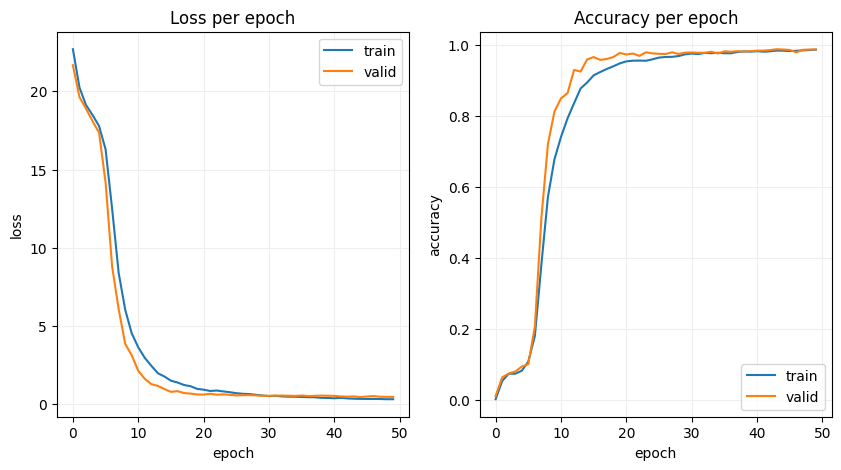

In [20]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
plot(history, 'loss', ax);

ax = plt.subplot(1, 2, 2)
plot(history, 'accuracy', ax);

### Export Model

Defines a module to save the model later and use it on edge devices. This model normalizes the image(s) and then feeds it forward to the model to get the model's output. Model's output is then decoded to return the result.

In [21]:
class Predictor(tf.Module):
    def __init__(self, model, *, ctc_decoder, tokenizer_invert, max_length=8):
        super(Predictor, self).__init__()
        
        self.max_length = max_length
        self.model = model
        self.ctc_decoder = ctc_decoder
        self.tokenizer_invert = tokenizer_invert


    def normalize(self, images):
        images = tf.cast(images, tf.float32)
        images = images / 127.5
        images = images - 1
        images = tf.transpose(images, perm=[0, 2, 1, 3])
        return images

    @tf.function(input_signature=[tf.TensorSpec(shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, 3], 
                                                dtype=tf.float32)])
    def __call__(self, images):
        images = self.normalize(images)
        y_pred = self.model(images, training=False)
        result = self.ctc_decoder(y_pred, max_length=self.max_length)
        return result

In [22]:
model.load_weights('./checkpoints/best.h5')
predictor = Predictor(model=model, 
                      ctc_decoder=CTCdecode, 
                      tokenizer_invert=tokenizer_invert)

In [23]:
images = []
label = []
prediction = []
for path, lbl in zip(test_paths, test_labels):
    file = tf.io.read_file(path)
    image = tf.image.decode_jpeg(file)
    image = tf.image.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
    y_pred = predictor(image[tf.newaxis, ...])
    y_pred = tf.strings.join(tokenizer_invert(y_pred[0])).numpy().decode('utf-8')
    images.append(image)
    label.append(lbl)
    prediction.append(y_pred)

images = np.array(images, dtype=np.float32)
label = np.array(label)
prediction = np.array(prediction)

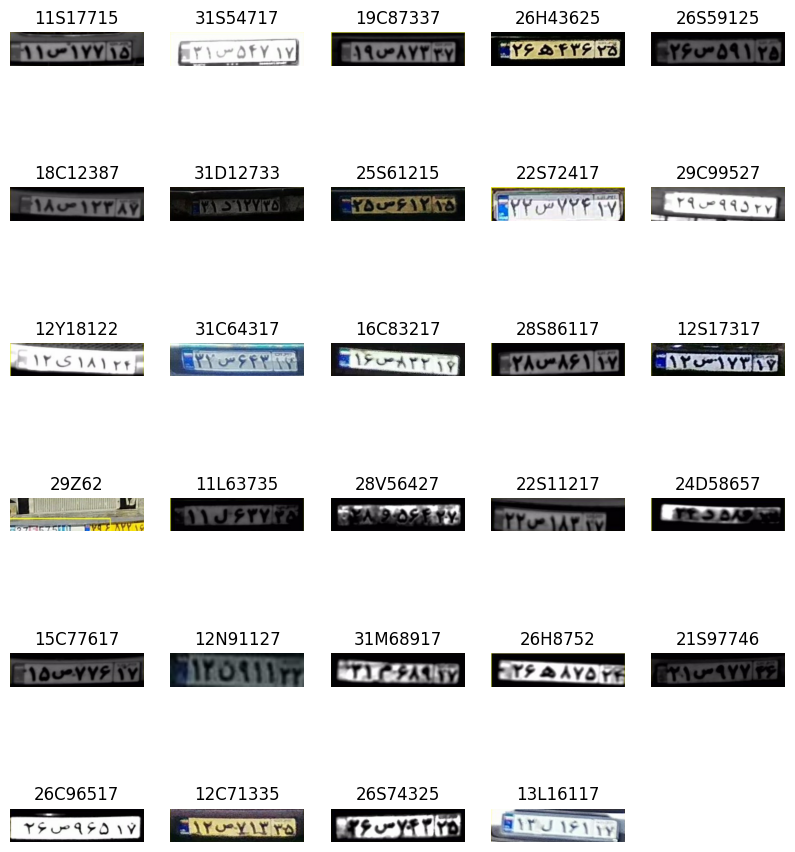

In [24]:
fig = plt.figure(figsize=(10, 40))
cnt = 0
for i in range(len(label)):
    if cnt >= 100: break
    if prediction[i] == label[i]: continue
        
    ax = plt.subplot(20, 5, cnt + 1)
    ax.imshow(images[i] / 255.0)
    ax.axis('off')
    ax.set_title(prediction[i])
    cnt += 1

## Export the model

In [25]:
tf.saved_model.save(predictor, './models/predictor.tf')

INFO:tensorflow:Assets written to: ./models/predictor.tf/assets


INFO:tensorflow:Assets written to: ./models/predictor.tf/assets


In [26]:
converter = tf.lite.TFLiteConverter.from_saved_model('./models/predictor.tf/')
# Enable the usage of select TensorFlow ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # Enable select TensorFlow ops.
]

# Disable experimental lowering of tensor list ops
converter._experimental_lower_tensor_list_ops = False
tflite = converter.convert()

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 54, Total Ops 184, % non-converted = 29.35 %
 * 47 ARITH ops, 6 TF ops, 1 TF_SAVED_MODEL ops

- arith.constant:   47 occurrences  (: 1, i64: 2, f32: 22, i32: 22)

  (i1: 2, i32: 2)


- tf.CTCGreedyDecoder:    1 occurrences  (i64: 1)
- tf.TensorListReserve:    1 occurrences  (: 1)
- tf.TensorListSetItem:    2 occurrences  (: 2)
- tf.TensorListStack:    2 occurrences  (f32: 2)
- tf_saved_model.session_initializer:    1 occurrences
  (f32: 9, i32: 4)
  (f32: 1)

  (i64: 2)
  (f32: 1, i32: 2)
  (f32: 3)
  (i64: 1)
  (f32: 1, i32: 1)
  (f32: 6)
  (f32: 2, i32: 4)
  (: 1)

  (i1: 2)
  (f32: 1)
  (f32: 6)
  (f32: 3)
  (f32: 8, i32: 1)

  (i64: 1, i32: 4)
  (i32: 4)
  (f32: 5, i32: 1)
  (f32: 2)
  (i64: 1, i32: 5)
  (f32: 1)
  (i64: 1)
  (f32: 2)
  (i64: 1, i32: 4)
  (f32: 1)
  (f32: 4)
  (f32: 5)
  (i32: 2)



In [27]:
with open('./models/predictor.tflite', 'wb') as tflite_file:
    tflite_file.write(tflite)